# Preparación de datos

In [1]:
# importo las librerías
import pandas as pd
import numpy as np

# defino la URL del dataset
csv_url = "https://raw.githubusercontent.com//ITACADEMYprojectes//projecteML//main//bank_dataset.CSV"

df = pd.read_csv(csv_url)

df.head()

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,deposit
0,59.0,admin.,married,secondary,no,2343,yes,no,unknown,5,may,1042,1,-1,0,unknown,yes
1,56.0,admin.,married,secondary,no,45,no,no,unknown,5,may,1467,1,-1,0,unknown,yes
2,41.0,technician,married,secondary,no,1270,yes,no,unknown,5,may,1389,1,-1,0,unknown,yes
3,55.0,services,married,secondary,no,2476,yes,no,unknown,5,may,579,1,-1,0,unknown,yes
4,54.0,admin.,married,tertiary,no,184,no,no,unknown,5,may,673,2,-1,0,unknown,yes


Para mi proyecto, necesito las características demográficas y financieras de los clientes, así que creo un *dataframe* que contenga únicamente estas variables. Incluyo todas las variables demográficas y financieras ya que, tal y como he visto durante el análisis exploratorio de datos, todas pueden ser relevantes para el modelo. 

In [2]:
df = df[['age','job','marital','education','default','balance','housing','loan','deposit']]

df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11162 entries, 0 to 11161
Data columns (total 9 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   age        11152 non-null  float64
 1   job        11162 non-null  object 
 2   marital    11157 non-null  object 
 3   education  11155 non-null  object 
 4   default    11162 non-null  object 
 5   balance    11162 non-null  int64  
 6   housing    11162 non-null  object 
 7   loan       11162 non-null  object 
 8   deposit    11162 non-null  object 
dtypes: float64(1), int64(1), object(7)
memory usage: 785.0+ KB


El *dataframe* tiene 11162 filas y 9 columnas.

### Imputación de valores faltantes

In [3]:
df.isnull().sum()

age          10
job           0
marital       5
education     7
default       0
balance       0
housing       0
loan          0
deposit       0
dtype: int64

Hay tres columnas que contienen valores *null*: `age`, `marital` y `education`. 

Dado que los valores que faltan estan relacionados con los datos demográficos de los clientes, utilizo el resto de datos disponibles como guía para imputar los faltantes: 
* `age`: mediana de edad de clientes con el mismo trabajo, estado civil y educación
* `marital`: moda de estado civil de clientes con el mismo trabajo y edad
* `education`: moda de educación de clientes con el mismo trabajo y edad

In [4]:
# sustituir 'age'
median_age = df.groupby(['job', 'marital','education'])['age'].transform(lambda x: x.median() if not x.isnull().all() else None)
df['age'] = df['age'].fillna(round(median_age))

# sustituir 'marital'
mode_marital = df.groupby(['job', 'age'])['marital'].transform(lambda x: x.mode()[0] if not x.isnull().all() else None)
df['marital'] = df['marital'].fillna(mode_marital)

# sustituir 'education'
mode_education = df.groupby(['job', 'age'])['education'].transform(lambda x: x.mode()[0] if not x.isnull().all() else None)
df['education'] = df['education'].fillna(mode_education)

In [5]:
df.isnull().sum()

age          0
job          0
marital      0
education    0
default      0
balance      0
housing      0
loan         0
deposit      0
dtype: int64

Se han imputado correctamente los valores faltantes.

### Tratamiento de valores desconocidos *(unknown)*

Muestro las categorias de las variables categóricas.

In [6]:
for column in df.select_dtypes(include=['object']).columns:
    print(f"La variable {column.upper()} tiene categorias: {df[column].nunique()}\
    \n{df[column].value_counts()}\
    \n \n------------------------\n")

La variable JOB tiene categorias: 12    
job
management       2566
blue-collar      1944
technician       1823
admin.           1334
services          923
retired           778
self-employed     405
student           360
unemployed        357
entrepreneur      328
housemaid         274
unknown            70
Name: count, dtype: int64    
 
------------------------

La variable MARITAL tiene categorias: 3    
marital
married     6353
single      3518
divorced    1291
Name: count, dtype: int64    
 
------------------------

La variable EDUCATION tiene categorias: 4    
education
secondary    5479
tertiary     3687
primary      1500
unknown       496
Name: count, dtype: int64    
 
------------------------

La variable DEFAULT tiene categorias: 2    
default
no     10994
yes      168
Name: count, dtype: int64    
 
------------------------

La variable HOUSING tiene categorias: 2    
housing
no     5881
yes    5281
Name: count, dtype: int64    
 
------------------------

La variable LOAN

Las variables `job` y `education` tienen categorías *unknown*. Para tratarlas, utilizo la misma estrategia que para imputar valores faltantes:
* `job`: moda de trabajo de clientes con el misma educación y edad; en caso de que no se rellenen todos, aplico de nuevo la imputación teniendo en cuenta únicamente la moda de trabajo de clientes con la misma edad
* `education`: moda de educación de clientes con el mismo trabajo y edad; en caso de que no se rellenen todos, aplico de nuevo la imputación teniendo en cuenta únicamente la moda de educación de clientes con el mismo trabajo

In [7]:
# sustituir 'job'
mode_job = df.groupby(['education', 'age'])['job'].transform(lambda x: x.mode()[0] if not x.isnull().all() else None)
df.loc[df['job'] == 'unknown', 'job'] = mode_job

mode_job2 = df.groupby(['age'])['job'].transform(lambda x: x.mode()[0] if not x.isnull().all() else None)
df.loc[df['job'] == 'unknown', 'job'] = mode_job2

In [8]:
# sustituir 'education'
mode_education = df.groupby(['job', 'age'])['education'].transform(lambda x: x.mode()[0] if not x.isnull().all() else None)
df.loc[df['education'] == 'unknown', 'education'] = mode_education

mode_education2 = df.groupby(['job'])['education'].transform(lambda x: x.mode()[0] if not x.isnull().all() else None)
df.loc[df['education'] == 'unknown', 'education'] = mode_education2

In [9]:
df[(df['job'] == 'unknown') | (df['education'] == 'unknown')]

,age,job,marital,education,default,balance,housing,loan,deposit


Se han imputado todos los valores desconocidos.

### Tratamiento de *outliers*

Tal y como he visto en el análisis exploratorio, las variables `age` y `balance` presentaban *outliers*. En lugar de eliminar directamente esos *outliers* (ya que suponen un porcentaje considerable del total), creo un segundo *dataframe* y los trato con la técnica de winsorización.

In [10]:
from scipy.stats.mstats import winsorize

df_winsorized = df.copy()

# reemplazo los outliers por el valor del percentil 95 o 5 más cercano
df_winsorized['age'] = winsorize(df_winsorized['age'], limits = [0.05, 0.05], inplace = True)
df_winsorized['balance'] = winsorize(df_winsorized['balance'], limits = [0.05, 0.05], inplace = True)

### Dividir el conjunto de datos

Separo el conjunto de datos en datos de entrenamiento y de prueba siguiendo los siguientes criterios:
* 75% datos de entrenamiento, 25% datos de prueba
* stratify de la variable objetivo (depósito) para mantener la misma proporción de clientes que contratan o no el producto financiero
* random_state = 0 para que la selección sea aleatoria

Dado que quiero utilizar modelo supervisado, separo las características de las etiquetas. 

In [11]:
df_winsorized.columns

Index(['age', 'job', 'marital', 'education', 'default', 'balance', 'housing',
       'loan', 'deposit'],
      dtype='object')

In [12]:
from sklearn.model_selection import train_test_split

X = df_winsorized.loc[:,['age', 'job', 'marital', 'education', 'default', 'balance', 'housing', 'loan']]
Y = df_winsorized.loc[:,['deposit']]

X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.25, random_state=0, stratify=Y)

print(f'Los datos de entrenamiento contienen {X_train.shape[0]} filas, {X_train.shape[1]} características y {Y_train.shape[1]} etiqueta.')
print(f'Los datos de prueba contienen {X_test.shape[0]} filas, {X_test.shape[1]} características y {Y_test.shape[1]} etiqueta.')

Los datos de entrenamiento contienen 8371 filas, 8 características y 1 etiqueta.
Los datos de prueba contienen 2791 filas, 8 características y 1 etiqueta.


### Codificación de variables categóricas

#### Label Encoding

Utilizo **Label Encoding** para las características `default`, `loan` y `housing` y la etiqueta `deposit`, ya que son binarias (yes/no). También utilizo este método para la característica `education`, al ser variable ordinal. 

In [13]:
binary_variable = ['default', 'loan', 'housing']

numeric_education = {'primary' : 1,
                     'secondary' : 2,
                     'tertiary' : 3}

for variable in binary_variable:
    X_train[variable] = X_train[variable].map({'no': 0, 'yes': 1}).astype(int)
    X_test[variable] = X_test[variable].map({'no': 0, 'yes': 1}).astype(int)

X_train['education'] = X_train['education'].map(numeric_education).astype(int)
X_test['education'] = X_test['education'].map(numeric_education).astype(int)

# convierto la etiqueta 'deposit' en 0 y 1, tanto de datos de entrenamiento como de prueba
Y_train['deposit'] = Y_train['deposit'].map({'no': 0, 'yes': 1}).astype(int)
Y_test['deposit'] = Y_test['deposit'].map({'no': 0, 'yes': 1}).astype(int)

In [14]:
X_train.head()

,age,job,marital,education,default,balance,housing,loan
3557,29.0,unemployed,single,3,0,70,0,0
1337,61.0,retired,married,2,0,6027,0,0
2497,36.0,management,married,3,0,2987,1,0
5575,37.0,self-employed,married,3,0,0,0,0
5045,43.0,management,married,3,0,0,0,0


In [15]:
Y_test.head()

,deposit
730,1
3781,1
6381,0
3944,1
9851,0


#### One-Hot-Encoding

Utilizo **One-Hot Encoding** para las características `job` y `marital`.

Antes de aplicar la codificación, agrupo las categorías de `job` para reducir la dimensionalidad, siguiendo el siguiente criterio:
* categorías sin agrupar: management, blue-collar, technician, admin. (para mantener el detalle de los grupos más representativos)
* servicios y atención al cliente: services, housemaid
* trabajadores independientes y emprendedores: self-employed, entrepreneur
* sin empleo o inactivos: unemployed, retired, student

In [16]:
grouped_jobs = {'management': 'management',
                'blue-collar': 'blue-collar',
                'technician': 'technician',
                'admin.': 'admin.',  
                'services': 'services_group',
                'housemaid': 'services_group',
                'self-employed': 'independent_group',
                'entrepreneur': 'independent_group',
                'unemployed': 'inactive_group',
                'retired': 'inactive_group',
                'student': 'inactive_group'}

X_train['job'] = X_train['job'].map(grouped_jobs)
X_test['job'] = X_test['job'].map(grouped_jobs)

In [17]:
X_train

,age,job,marital,education,default,balance,housing,loan
3557,29.0,inactive_group,single,3,0,70,0,0
1337,61.0,inactive_group,married,2,0,6027,0,0
2497,36.0,management,married,3,0,2987,1,0
5575,37.0,independent_group,married,3,0,0,0,0
5045,43.0,management,married,3,0,0,0,0
...,...,...,...,...,...,...,...,...
7666,47.0,technician,married,3,0,545,1,0
2707,26.0,management,single,3,0,808,0,0
9523,46.0,management,single,2,0,244,1,0
5303,33.0,technician,married,2,0,2362,1,0


In [18]:
from sklearn.preprocessing import OneHotEncoder

encoder = OneHotEncoder()

encoded_X_train = X_train.copy()
encoded_X_test = X_test.copy()

encoding_variable = ['job', 'marital']

for variable in encoding_variable:
    # encoding de datos de entrenamiento
    encoded_train_results = encoder.fit_transform(X_train[[variable]])
    encoded_train_columns = pd.DataFrame(encoded_train_results.toarray(), 
                                         columns=encoder.get_feature_names_out([variable]), 
                                         index=X_train.index)
    encoded_X_train = pd.concat([encoded_X_train, encoded_train_columns], axis="columns")

    # encoding de datos de prueba
    encoded_test_results = encoder.fit_transform(X_test[[variable]])
    encoded_test_columns = pd.DataFrame(encoded_test_results.toarray(), 
                                         columns=encoder.get_feature_names_out([variable]), 
                                         index=X_test.index)
    encoded_X_test = pd.concat([encoded_X_test, encoded_test_columns], axis="columns")

# elimino las columnas categoricas iniciales
encoded_X_train = encoded_X_train.drop(columns=encoding_variable)
encoded_X_test = encoded_X_test.drop(columns=encoding_variable)

In [19]:
print(f'Los datos de entrenamiento contienen {encoded_X_train.shape[0]} filas, {encoded_X_train.shape[1]} características y {Y_train.shape[1]} etiqueta.')
print(f'Los datos de prueba contienen {encoded_X_test.shape[0]} filas, {encoded_X_test.shape[1]} características y {Y_test.shape[1]} etiqueta.')

Los datos de entrenamiento contienen 8371 filas, 16 características y 1 etiqueta.
Los datos de prueba contienen 2791 filas, 16 características y 1 etiqueta.


In [20]:
encoded_X_train.head()

,age,education,default,balance,housing,loan,job_admin.,job_blue-collar,job_inactive_group,job_independent_group,job_management,job_services_group,job_technician,marital_divorced,marital_married,marital_single
3557,29.0,3,0,70,0,0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
1337,61.0,2,0,6027,0,0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
2497,36.0,3,0,2987,1,0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0
5575,37.0,3,0,0,0,0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0
5045,43.0,3,0,0,0,0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0


In [21]:
encoded_X_test.head()

,age,education,default,balance,housing,loan,job_admin.,job_blue-collar,job_inactive_group,job_independent_group,job_management,job_services_group,job_technician,marital_divorced,marital_married,marital_single
730,46.0,3,0,4,0,0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0
3781,61.0,2,0,1574,0,0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
6381,31.0,2,0,290,1,0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0
3944,61.0,2,0,2801,1,1,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
9851,45.0,3,0,6027,0,0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0


Después de aplicar las técnicas de codificación, observamos que todas las variables son numéricas. Además, pasamos de tener 9 a 16 características. 

### Estandarización de características

La estandarización ayuda a que cada característica contribuya de manera equitativa en el modelo, lo que es esencial para obtener resultados significativos y fiables en modelos y técnicas sensibles a la escala.

En recursos adicionales, he visto que no es necesario estandarizar las variables categóricas que fueron codificadas con Label-Encoding o One-Hot-Encoding, es decir, ya están en una escala consistente y lista para su uso en modelos. Por tanto, únicamente estandarizo las variables `age` y `balance`.

In [22]:
from sklearn.preprocessing import StandardScaler

# selecciono solo las columnas a estandarizar
scale_variable = ['age', 'balance']

# creo el escalador 
scaler = StandardScaler()

# ajusto el escalador y aplico la estandarización a los datos de entrenamiento
encoded_X_train[scale_variable] = scaler.fit_transform(encoded_X_train[scale_variable])

# aplico la estandarizacion a los datos de prueba
encoded_X_test[scale_variable] = scaler.transform(encoded_X_test[scale_variable])

In [23]:
encoded_X_train.head()

,age,education,default,balance,housing,loan,job_admin.,job_blue-collar,job_inactive_group,job_independent_group,job_management,job_services_group,job_technician,marital_divorced,marital_married,marital_single
3557,-1.124433,3,0,-0.716704,0,0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
1337,1.918648,2,0,2.848559,0,0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
2497,-0.458759,3,0,1.029120,1,0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0
5575,-0.363663,3,0,-0.758599,0,0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0
5045,0.206915,3,0,-0.758599,0,0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0


### Reducción de dimensionalidad

La técnica de One-Hot-Encoding implica la posibilidad del riesgo por alta dimensionalidad y por multicolinealidad. Para mitigar esto, aplico la técnica de reducción de dimensionalidad por PCA. 

In [24]:
from sklearn.decomposition import PCA

# obtengo los componentes principales
pca = PCA()

# ajusto el pca y aplico la reducción de dimensionalidad a los datos de entrenamiento
reduced_encoded_X_train = pca.fit_transform(encoded_X_train)

# aplico la reducción de dimensionalidad a los datos de prueba
reduced_encoded_X_test = pca.transform(encoded_X_test)

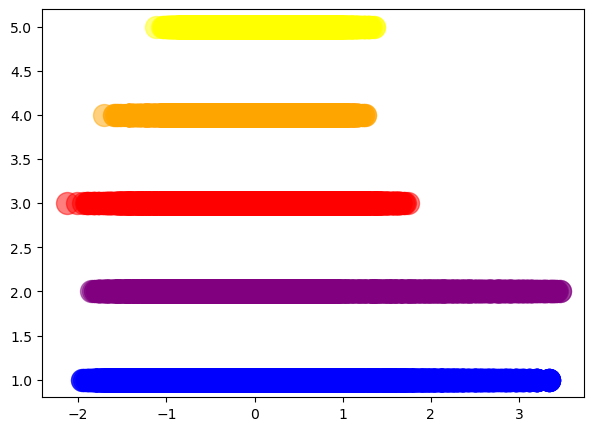

In [25]:
import matplotlib.pyplot as plt

# visualización - datos de entrenamiento
plt.figure(figsize=(7, 7))
plt.axes().set_aspect("equal")
plt.scatter(reduced_encoded_X_train[:, 0], [1] * reduced_encoded_X_train[:, 0].size, s=250, color="blue", alpha=0.5)
plt.scatter(reduced_encoded_X_train[:, 1], [2] * reduced_encoded_X_train[:, 1].size, s=250, color="purple", alpha=0.5)
plt.scatter(reduced_encoded_X_train[:, 2], [3] * reduced_encoded_X_train[:, 2].size, s=250, color="red", alpha=0.5)
plt.scatter(reduced_encoded_X_train[:, 3], [4] * reduced_encoded_X_train[:, 3].size, s=250, color="orange", alpha=0.5)
plt.scatter(reduced_encoded_X_train[:, 4], [5] * reduced_encoded_X_train[:, 4].size, s=250, color="yellow", alpha=0.5)

plt.ylim((0.8, 5.2))
plt.show()

In [26]:
# configuro el formato para evitar la notación científica
np.set_printoptions(suppress=True, precision=8)

print("Varianza explicada por cada componente:\n", pca.explained_variance_)
print("\nProporción de varianza explicada por cada componente:\n", pca.explained_variance_ratio_)

Varianza explicada por cada componente:
 [1.21652626 0.95507671 0.51829364 0.3395342  0.23088791 0.17246307
 0.13954859 0.13204406 0.11935649 0.11319857 0.1052015  0.09792889
 0.06781686 0.01515957 0.         0.        ]

Proporción de varianza explicada por cada componente:
 [0.2880691  0.22615877 0.12273009 0.08040049 0.05467344 0.04083864
 0.03304461 0.03126756 0.02826319 0.02680502 0.02491134 0.02318921
 0.01605879 0.00358973 0.         0.        ]


Al aplicar PCA, observo que los primeros 6 componentes ya explican el 81.3% de la varianza de los datos. Si se quisiera un mayor porcentaje de varianza, se podría seleccionar más cantidad de componentes como entrada para el modelo de ML. Es evidente que esta técnica permite reducir la dimensionalidad de 16 características originales a, por lo menos, la mitad, reteniendo la mayor parte de la información, y permitiendo simplificar el modelo o mejorar el rendimiento computacional. 

Sin embargo, lo que me preocupa es que si aplico los componentes principales como entrada para el modelo, perdería la "conexión" directa con las características originales. Esto podría dificultar la interpretación en términos de características oginales. Por ejemplo, en mi proyecto quería ver qué características (demográficas o financieras) influían más en la contratación de depósito y para ello seleccioné el Random Forest, que facilita la oportunidad de calcular el *feature importance*. Sin embargo, si uso los componentes principales, el Random Forest ya no me daría las importancias en términos de las características originales.

Por tanto, para el modelo de Random Forest utilizaré los datos sin reducir la dimensionalidad, ya que los árboles seleccionan automáticamente las características relevantes en cada partición, lo que hace que la reducción de dimensionalidad no sea tan necesaria.